In [1]:
import cv2
import sklearn
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import PIL
# data visualization stack
import matplotlib.pyplot as plt
%matplotlib inline
#import seaborn as sns
#sns.set_style('whitegrid')
from PIL import Image
# miscellaneous
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

from skimage import feature, io, filters, util, exposure, restoration
from matplotlib.colors import ListedColormap

In [7]:
def createTransparentMap(cmap):
  # Get the colormap colors
  my_cmap = cmap(np.arange(cmap.N))
  # Set alpha
  my_cmap[:,-1] = np.linspace(0, 1, cmap.N)
  # Create new colormap
  return ListedColormap(my_cmap)

In [3]:
sigma = 0.6
redMap = createTransparentMap(plt.cm.plasma)
grayMap = createTransparentMap(plt.cm.gray)
detector = feature.CENSURE()

In [8]:
 # Read image 
src = cv2.imread("Welds/laser_cut_cropped.png", cv2.IMREAD_GRAYSCALE)

# Basic threhold example 
th, dst = cv2.threshold(src, 0, 255, cv2.THRESH_BINARY) 
res = cv2.imwrite("img1/thresh_binary.png", dst) 

# Thresholding with maxValue set to 128
th, dst = cv2.threshold(src, 0, 128, cv2.THRESH_BINARY) 
cv2.imwrite("img1/opencv-thresh-binary-maxval.jpg", dst) 
 
# Thresholding with threshold value set 127 
th, dst = cv2.threshold(src, 127, 110, cv2.THRESH_BINARY) 
cv2.imwrite("img1/opencv-thresh-binary.jpg", dst) 
 
# Thresholding using THRESH_BINARY_INV 
th, dst = cv2.threshold(src, 110, 110, cv2.THRESH_BINARY_INV) 
cv2.imwrite("img1/opencv-thresh-binary-inv.jpg", dst) 
 
# Thresholding using THRESH_TRUNC 
th, dst = cv2.threshold(src, 200, 255, cv2.THRESH_TRUNC) 
cv2.imwrite("img1/opencv-thresh-trunc.jpg", dst) 
 
# Thresholding using THRESH_TOZERO 
th, dst = cv2.threshold(src, 127, 255, cv2.THRESH_TOZERO) 
cv2.imwrite("img1/opencv-thresh-tozero.jpg", dst) 
 
# Thresholding using THRESH_TOZERO_INV 
th, dst = cv2.threshold(src, 100, 100, cv2.THRESH_TOZERO_INV) 
cv2.imwrite("img1/opencv-thresh-to-zero-inv.jpg", dst) 


False

In [144]:
# Thresholding using THRESH_TRUNC 
th, dst = cv2.threshold(src, 200, 255, cv2.THRESH_TRUNC) 
cv2.imwrite("img1/opencv-thresh-trunc.jpg", dst) 

True

In [9]:
def preprocessing(image):
    # Apply thresholding
    th, dst = cv2.threshold(image, 100, 170, cv2.THRESH_TOZERO_INV) 
    dst = cv2.GaussianBlur(dst, (7, 7), 0)
    # Apply contrast filter
    contrast_filtered = cv2.equalizeHist(dst)
    print('Preprocessing: SimpleBlobDetector')
    plt.figure(figsize=(20, 5))
    plt.imshow(dst)
    plt.show()
    return dst

In [10]:
def blob_detection(image_edge, image):
    detector = cv2.SimpleBlobDetector_create() 
    keypoints = detector.detect(image)
    # Draw detected blobs as red circles.
    # cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures the size of the circle corresponds to the size of blob
    
    im_with_keypoints = cv2.drawKeypoints(image_edge, keypoints, np.array([]), (255, 0, 0), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    for kp in keypoints:
        center = tuple(map(int, kp.pt))  # Convert keypoint position to integer tuple
        radius = int(kp.size/1.5)  # Calculate radius based on keypoint size
        color = (0, 0, 0)  # Red color
        thickness = -1  # Negative thickness will fill the circle
        #print(f'Blob detection center: {center}')
        cv2.circle(image_edge, center, radius, color, thickness)

    print('Blob detection result: SimpleBlobDetector')
    # Show keypoints
    plt.figure(figsize=(20, 5))
    plt.imshow(image_edge)
    plt.show()
    return image_edge

In [12]:
def edge_detection(img):
    plt.figure(figsize=(20, 5))
    plt.imshow(img)
    plt.show()

    img_blur =  cv2.GaussianBlur(img, (3, 3), 0) 
    # detect the contours on the binary image using cv2.CHAIN_APPROX_NONE   
    edges = cv2.Canny(image=img_blur, threshold1=50, threshold2=100) # Canny Edge Detection

    # Find contours in the edge image
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a copy of the original image to draw contours on
    image_copy = img_blur.copy()

    alpha = 0 
    beta = 220
    im_out = cv2.convertScaleAbs(image_copy, alpha=alpha, beta=beta)
    # Draw the contours on the copy of the image
    cv2.drawContours(im_out, contours, -1, (0, 0, 0), thickness=5)  # Change color and thickness as needed
    print('Edge detection result: Canny, threshold1=50, threshold2=100')
    plt.figure(figsize=(20, 5))      
    # see the results
    plt.imshow(im_out)
    plt.show()
    return im_out

In [13]:
def process_images(input_folder, output_folder):
    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # List all image files in the input folder
    image_files = [f for f in os.listdir(input_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    for image_file in image_files:
        # Read the image
        image_path = os.path.join(input_folder, image_file)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        result_preprocessed = image.copy()
        if image is None:
            print(f"Could not read {image_file}. Skipping...")
            continue
        
        result_edge = edge_detection(image)     
        result_preprocessed = preprocessing(result_preprocessed)
        result_blob = blob_detection(result_edge,  result_preprocessed)

        
        # Save the processed image
        output_path = os.path.join(output_folder, "test1_" + image_file)
        cv2.imwrite(output_path, result_blob)
        
        print(f"Processed {image_file} and saved to {output_path}")


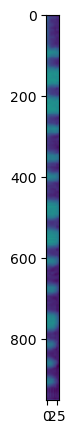

Edge detection result: Canny, threshold1=50, threshold2=100


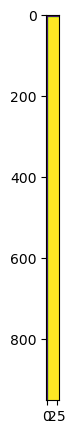

Preprocessing: SimpleBlobDetector


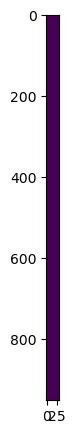

Blob detection result: SimpleBlobDetector


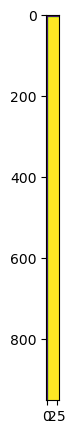

Processed laser_cut_cropped.png and saved to img1/test\test1_laser_cut_cropped.png


In [14]:
# Replace these paths with your actual input and output folders
input_folder = 'Welds/'
output_folder = 'img1/test'

process_images(input_folder, output_folder)

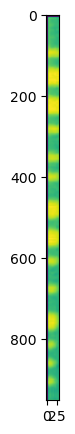

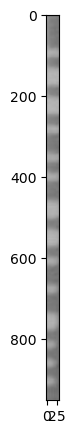

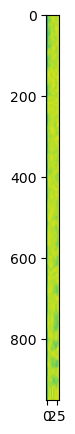

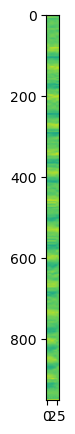

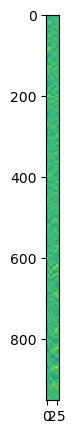

In [16]:
#pic = cv2.imread("img\W0001_0007.png", cv2.IMREAD_GRAYSCALE)
pic = cv2.imread("Welds/laser_cut_cropped.png", cv2.IMREAD_GRAYSCALE)

# Blur the image for better edge detection
img_blur =  cv2.GaussianBlur(pic, (3, 3), 0) 
# Canny Edge Detection
edges = cv2.Canny(image=img_blur, threshold1=30, threshold2=80) # Canny Edge Detection

# Find contours in the edge image
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create a copy of the original image to draw contours on
image_copy = img_blur.copy()

alpha = 0.1  
beta = 300
im_out = cv2.convertScaleAbs(image_copy, alpha=alpha, beta=beta)
# Draw the contours on the copy of the image
cv2.drawContours(image_copy, contours, -1, (0, 0, 0), thickness=5)  # Change color and thickness as needed


# Display Canny Edge Detection Image
plt.figure(figsize=(20, 5))      
    # see the results
plt.imshow(image_copy)
plt.show()

detector = cv2.SimpleBlobDetector_create() 
keypoints = detector.detect(pic)
# Draw detected blobs as red circles.
# cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures the size of the circle corresponds to the size of blob
im_with_keypoints = cv2.drawKeypoints(img_blur, keypoints, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.figure(figsize=(20, 5))      
    # see the results
plt.imshow(im_with_keypoints)
plt.show()
  
# Sobel Edge Detection
sobelx = cv2.Sobel(src=img_blur, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=5) # Sobel Edge Detection on the X axis
plt.figure(figsize=(20, 5))      
    # see the results
plt.imshow(sobelx)
plt.show()

sobely = cv2.Sobel(src=img_blur, ddepth=cv2.CV_32F, dx=0, dy=1, ksize=3) # Sobel Edge Detection on the Y axis
plt.figure(figsize=(20, 5))      
    # see the results
plt.imshow(sobely)
plt.show()

sobelxy = cv2.Sobel(src=img_blur, ddepth=cv2.CV_64F, dx=1, dy=1, ksize=5) # Combined X and Y Sobel Edge Detection
# Display Sobel Edge Detection Images
plt.figure(figsize=(20, 5))      
    # see the results
plt.imshow(sobelxy)
plt.show()
 
cv2.destroyAllWindows()

# Clastering - best fit for Laser pic (I think).

In [17]:
from sklearn.cluster import KMeans

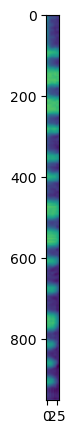

In [18]:
# Load the image
image = cv2.imread('Welds/laser_cut_cropped.png', cv2.IMREAD_GRAYSCALE)


# Image Smoothing
smoothed_image = cv2.GaussianBlur(image, (5, 5), 0)  # Apply Gaussian blur for smoothing
plt.figure(figsize=(20, 5))      
    # see the results
plt.imshow(smoothed_image)
plt.show()


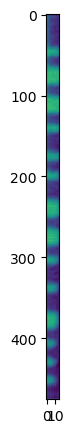

In [19]:

# Downsampling
downsample_factor = 0.5  # Downsample the image by a factor
downsampled_image = cv2.resize(image, None, fx=downsample_factor, fy=downsample_factor)
# Image Quantization

plt.figure(figsize=(20, 5))      
    # see the results
plt.imshow(downsampled_image)
plt.show()

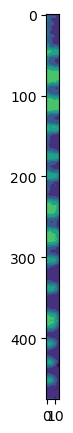

In [20]:
# Image Quantization
quantization_levels = 16  # Reduce the number of unique pixel values
quantized_image = np.floor_divide(downsampled_image, 256 // quantization_levels) * (256 // quantization_levels)

plt.figure(figsize=(20, 5))      
    # see the results
plt.imshow(quantized_image)
plt.show()


In [21]:
from sklearn.cluster import KMeans, DBSCAN, OPTICS
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [22]:

# Reshape the images for KMeans

smoothed_flat = smoothed_image.reshape((-1, 1))
quantized_flat = quantized_image.reshape((-1, 1))
downsampled_flat = downsampled_image.reshape((-1, 1))
original_flat = image.reshape((-1, 1))

# Apply KMeans clustering
n_clusters = 2  # Number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)


In [23]:

# Fit and predict on each preprocessed image

smoothed_labels = kmeans.fit_predict(smoothed_flat)
quantized_labels = kmeans.fit_predict(quantized_flat)
downsampled_labels = kmeans.fit_predict(downsampled_flat)


In [24]:
original_labels = kmeans.fit_predict(original_flat)

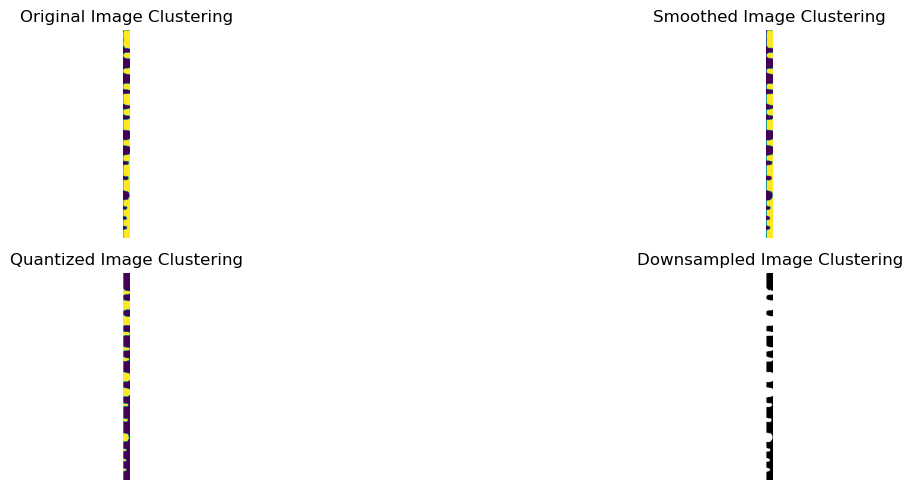

In [25]:

# Visualize the results
fig, axes = plt.subplots(2, 2, figsize=(20, 5))

axes[0, 0].imshow(original_labels.reshape(image.shape), cmap='viridis')
axes[0, 0].set_title('Original Image Clustering')
axes[0, 0].axis('off')

axes[0, 1].imshow(smoothed_labels.reshape(smoothed_image.shape), cmap='viridis')
axes[0, 1].set_title('Smoothed Image Clustering')
axes[0, 1].axis('off')

axes[1, 0].imshow(quantized_labels.reshape(quantized_image.shape), cmap='viridis')
axes[1, 0].set_title('Quantized Image Clustering')
axes[1, 0].axis('off')

axes[1, 1].imshow(downsampled_labels.reshape(downsampled_image.shape), cmap='gray')
axes[1, 1].set_title('Downsampled Image Clustering')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()


In [26]:
def clustering_images(input_folder, output_folder):
    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # List all image files in the input folder
    image_files = [f for f in os.listdir(input_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    for image_file in image_files:
        # Read the image
        image_path = os.path.join(input_folder, image_file)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
       
        if image is None:
            print(f"Could not read {image_file}. Skipping...")
            continue
        
        original_flat = image.reshape((-1, 1)) 
        original_labels = kmeans.fit_predict(original_flat)
        result = original_labels.reshape(image.shape)
        plt.figure(figsize=(20, 5))   
        plt.imshow(result, cmap='gray')
        plt.show()
        
        # Save the processed image
        output_path = os.path.join(output_folder, "cluster1_" + image_file)
        cv2.imwrite(output_path, result)
        
        print(f"Processed {image_file} and saved to {output_path}")

In [27]:
# Apply KMeans clustering
n_clusters = 2  # Number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

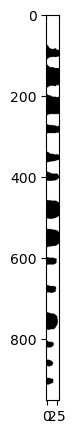

Processed laser_cut_cropped.png and saved to img1/cluster\cluster1_laser_cut_cropped.png


In [29]:
input_folder = 'welds/'
output_folder = 'img1/cluster'

clustering_images(input_folder, output_folder)